# 고양이, 개 분류 - CNN v2


In [23]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-18 02:25:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.215.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   144MB/s    in 0.5s    

2022-01-18 02:25:10 (144 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [24]:
!unzip cats_and_dogs_filtered.zip > /dev/null

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [25]:
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

In [26]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

validation_cats_fnames = os.listdir(validation_cats_dir)
validation_dogs_fnames = os.listdir(validation_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.976.jpg', 'cat.230.jpg', 'cat.493.jpg', 'cat.626.jpg', 'cat.186.jpg']
['dog.362.jpg', 'dog.98.jpg', 'dog.667.jpg', 'dog.766.jpg', 'dog.332.jpg']


In [27]:
# 파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

In [28]:
# !ls -l cats_and_dogs_filtered/train/cats | more

## 이미지 확인

In [29]:
import cv2 
from PIL import Image
import matplotlib.pyplot as plt

In [30]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

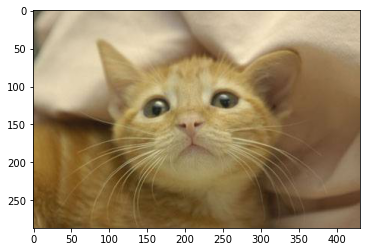

In [31]:
img = Image.open(fname)
plt.imshow(img);

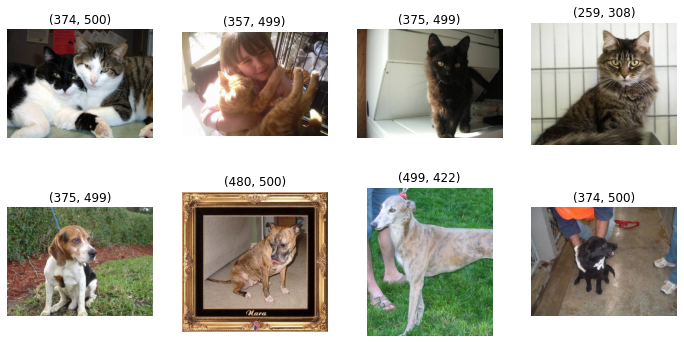

In [32]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])

    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])

plt.show()

## 모델 구성

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [34]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 36, 36, 32)       

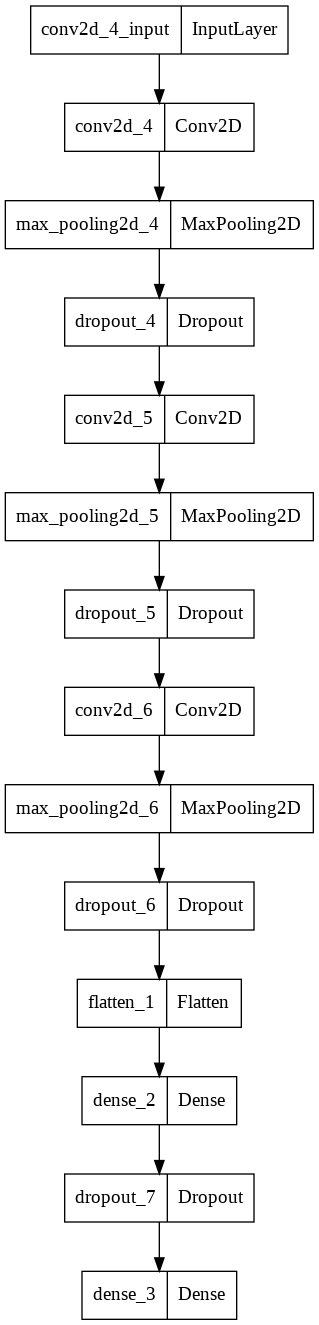

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model)

## 모델 설정

In [36]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.01, decay=1e-8),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

* 파일에서 이미지 데이터 읽어오는 방법

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [38]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [39]:
train_dir

'cats_and_dogs_filtered/train'

## callback 정의

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

## 모델 실행

In [41]:
hist = model.fit(
    train_generator, 
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=100,        # 한 번의 epoch에서 훈련에 사용 할 batch의 개수
    validation_steps=50,       # 한 번의 epoch가 끝났을 때, 테스트에 사용되는 batch의 개수
    verbose=2,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.68091, saving model to best-cat-dog-v2.h5
100/100 - 9s - loss: 32.6988 - accuracy: 0.5190 - val_loss: 0.6809 - val_accuracy: 0.5440 - 9s/epoch - 91ms/step
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.68091
100/100 - 8s - loss: 0.8047 - accuracy: 0.4940 - val_loss: 0.9255 - val_accuracy: 0.5000 - 8s/epoch - 79ms/step
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.68091
100/100 - 8s - loss: 1.0332 - accuracy: 0.4910 - val_loss: 0.6946 - val_accuracy: 0.5000 - 8s/epoch - 79ms/step
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.68091
100/100 - 8s - loss: 0.8013 - accuracy: 0.4870 - val_loss: 0.6932 - val_accuracy: 0.5000 - 8s/epoch - 79ms/step
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.68091
100/100 - 8s - loss: 0.9325 - accuracy: 0.5030 - val_loss: 0.6957 - val_accuracy: 0.5020 - 8s/epoch - 79ms/step
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.68091
100/100 - 8s - loss

In [42]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

## 테스트 이미지 분류

In [ ]:
from google.colab import files

up = files.upload()

TypeError: ignored

In [ ]:
img = cv2.imread('cat.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

In [ ]:
# 150 x 150 size
img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_AREA)
plt.imshow(img), plt.title(img.shape[:-1]);

In [ ]:
best_model.predict(img.reshape(1,150,150,3))

In [ ]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:      # 150 x 150 보다 큰 이미지
        img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")


## 학습과정 시각화

In [ ]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()